## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## First, compute the camera calibration and distortion coefficients using chessboard images



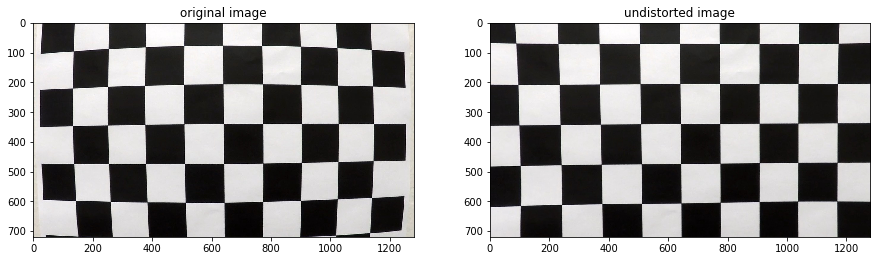

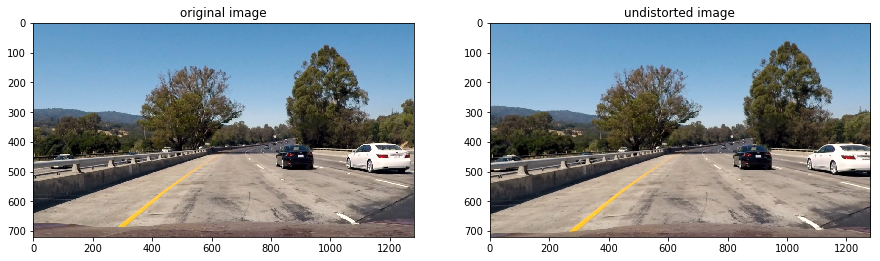

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline

# Find all corners. Build objpoints  and imgpoints array.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners


# i=1
# plt.figure(1,(15,15))
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)




# Compute the camera calibration and distortion coefficients
img_size = tuple([1280,720])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size, None, None)  



## Choose the 'calibration1.jpg' as a example to display the corners ##
## and result of calibration and distortion ##
example = plt.imread('camera_cal/calibration1.jpg')
plt.figure(1,(15,15))
# Display the original image.
plt.subplot(1,2,1)
plt.imshow(example)
plt.title("original image")
#Display the undistorted image.
example_undist = cv2.undistort(example, mtx, dist, None, mtx)
plt.subplot(1,2,2)
plt.imshow(example_undist)
plt.title("undistorted image")

## Another example 
example = plt.imread('test_images/test1.jpg')
plt.figure(2,(15,15))
# Display the original image.
plt.subplot(1,2,1)
plt.imshow(example,'gray')
plt.title("original image")
#Display the undistorted image.
example_undist = cv2.undistort(example, mtx, dist, None, mtx)
plt.subplot(1,2,2)
plt.imshow(example_undist,'gray')
plt.title("undistorted image")

## Use "straight_lines1.jpg" to get the the M matrix of perspective transform. 

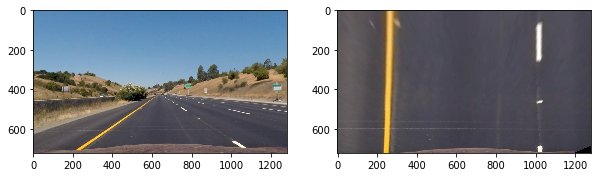

In [2]:
# Manually choose 4 source points on the image, and store them in src
src = np.float32([[498.0544747081712, 490.58365758754866],
            [799.3385214007782, 490.58365758754866],
            [1265.058365758755, 699.7665369649806],
            [94.63035019455253, 699.7665369649806]])

# Define corresponding distination points.
offset = 100 # offset for dst points
img_size = tuple([1280,720])
dst = np.float32([[offset, 0], [img_size[0]-offset, offset], 
                  [img_size[0]-offset, img_size[1]], 
                  [offset, img_size[1]]])

# Calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
M_revise = cv2.getPerspectiveTransform(dst, src)
# Read in the image
image_M = plt.imread('test_images/straight_lines1.jpg')
# image_M = plt.imread('Capture.jpg')
#Undistort the image
undist_M = cv2.undistort(image_M, mtx, dist, None, mtx)
# Warp the image with M
warped_M = cv2.warpPerspective(undist_M, M, img_size,flags=cv2.INTER_LINEAR)
#Show both the original image and the warped image.
plt.figure(1,(10,10))
plt.subplot(1,2,1)
plt.imshow(undist_M)
plt.subplot(1,2,2)
plt.imshow(warped_M)


## Define a class to store and processing fitted lines information for iteration from frame to frame

In [3]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # polynomial coefficients of the last 3 fits of the line
        self.recent_fit = []
        # average x values of the fitted line over the last 3 iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last 3 iterations
        self.best_fit = None  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 0 

    def Detected(self,x_base):
#   The Detect function functions from the third frame      
        if len(self.recent_xfitted) > 2:
            self.detected = (abs(self.bestx-x_base) <20)
        return self.detected
        
    def Update(self, x,y):
        iterations = 5
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = 719 #Calculate the curvature of the bottom of the image
        
#         Fit a second order polynomial to the line, in wraped image frame.
        new_fit = np.polyfit(y, x, 2)
    
#         Fit a second order polynomial to the line, in real world frame.
        new_fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
       
        newx = new_fit[0] * 719**2 + new_fit[1] * 719 + new_fit[2]
        newradius_of_curvature = ((1 + (2*new_fit_cr[0]*y_eval*ym_per_pix + 
                                new_fit_cr[1])**2)**1.5) / np.absolute(2*new_fit_cr[0])
        # Consider only the frame with mild changes on the x value of the top and bottom of fitted line, when compared with 
        # the averaged fitted line over the last 5 iterations
        if (len(self.recent_fit) < 5 or (abs(new_fit[2]- self.best_fit[2])<150 and\
            abs(newx- self.bestx)<150 )): 
    #         Calculate and update variables 
            self.recent_fit.append(new_fit)
            if len(self.recent_fit)> iterations:
                del(self.recent_fit[0])
            self.recent_xfitted.append(newx)
            if len(self.recent_xfitted)> iterations:
                del(self.recent_xfitted[0])
            self.bestx = sum(self.recent_xfitted)/len(self.recent_xfitted)
            self.best_fit = np.mean(self.recent_fit,0)

            newradius_of_curvature = ((1 + (2*new_fit_cr[0]*y_eval*ym_per_pix + 
                                        new_fit_cr[1])**2)**1.5) / np.absolute(2*new_fit_cr[0])
            
            if  self.radius_of_curvature :
                if abs(newradius_of_curvature - self.radius_of_curvature) < 2000:
                    self.radius_of_curvature = newradius_of_curvature
                    self.line_base_pos = (newx - 640) *xm_per_pix
            else:
                    self.radius_of_curvature = newradius_of_curvature
                    self.line_base_pos = (newx - 640) *xm_per_pix
    def GetCurvature(self):
        return self.radius_of_curvature
         
    def GetBestFit(self):
        return self.best_fit

## Define a funtion to process the input image. 

In [4]:
def Image_Processing(img):
    
#     Undistort the raw image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
#     Convert the undistort RGB image to HLS image.
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    g_channel = undist [:,:,2]
    s_channel = hls[:,:,2]
    
#     Calculate Sobel y
    sobely = cv2.Sobel(g_channel, cv2.CV_64F, 1, 0) 
    # Absolute y derivative
    abs_sobely = np.absolute(sobely) 
    # Rescale the abs_sobely 
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
#     Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & 
             (scaled_sobel <= thresh_max)] = 1
    
#     Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
#     Combine the two binary thresholds
    combined_binary = np.zeros_like(sybinary)
    combined_binary[(s_binary == 1) | (sybinary == 1)] = 1
    
    
#     Perspective Transform
    binary_warped = cv2.warpPerspective(combined_binary, M, img_size,flags=cv2.INTER_LINEAR)

    return binary_warped,undist


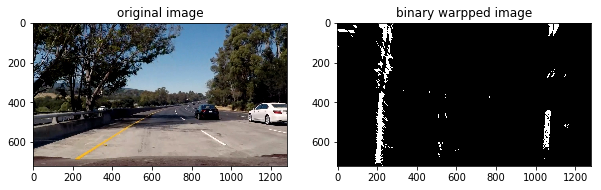

In [5]:
# Test the Image_Processing function on 'test5.jpg'
# Read in the image
test = plt.imread('test_images/test5.jpg')
test_result,test_undist = Image_Processing(test)
plt.figure(1,(10,20))
plt.subplot(1,2,1)
plt.imshow(test)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(test_result,'gray')
plt.title('binary warpped image')

## Define a function to find the lines and measure curvature on the binary image.

In [6]:
def SearchPixels (binary_warped,leftlines,rightlines):

# Set some HYPERPARAMETERS
    margin = 50  # Set the width of the margin of searching and sliding window
    nwindows = 9  # Choose the number of sliding windows
    minpix = 50  # Set minimum number of pixels found to recenter window
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
#     Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#   Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#   Find the peak of the left and right halves of the histogram
#   These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    if (leftlines.Detected(leftx_base) and rightlines.Detected(rightx_base)):
#         Set the area of search based on activated x-values \
#         within the +/- margin of our polynomial function
        left_fit = leftlines.GetBestFit()
        right_fit = rightlines.GetBestFit()
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                           left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                            left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                            right_fit[1]*nonzeroy + right_fit[2] + margin)))

    else:
#         Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
#         Identify the x and y positions of all nonzero pixels in the image
#         Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base
#         Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

#         Step through the windows one by one
        for window in range(nwindows):
#             Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
#             Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        

#             Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
        
#             If  pixels number> minpix, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
#         Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
#         Avoids an error if the above is not implemented fully
            pass

#     Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx,lefty,rightx,righty

    

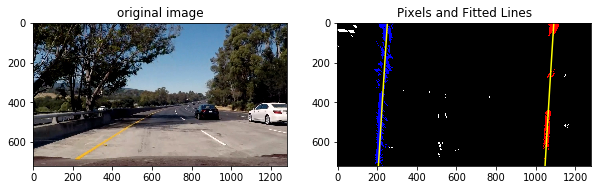

In [7]:
## Test the SearchPixel function on 'test5.jpg' ##

# Read in the image
test = plt.imread('test_images/test5.jpg')
tleftlines = Line()
trightlines = Line()
#Get useful pixels
test_result,test_undist = Image_Processing(test)
tleftx,tlefty,trightx,trighty = SearchPixels(test_result,tleftlines,trightlines)
#Get fitted coefficients
tleftlines.Update(tleftx,tlefty)
trightlines.Update(trightx,trighty)
tleft_fit = tleftlines.GetBestFit()
tright_fit = trightlines.GetBestFit()

ploty = np.linspace(0, test_result.shape[0]-1, test_result.shape[0] )
tleftfitx = tleft_fit[0] * ploty**2 + tleft_fit[1] * ploty + tleft_fit[2]  
trightfitx = tright_fit[0] * ploty**2 + tright_fit[1] * ploty + tright_fit[2]  

# Create an image to draw on and 
# Color in left and right line pixels
out_img = np.dstack((test_result, test_result, test_result))*255
out_img [tlefty,tleftx] = [0,0,255]
out_img [trighty,trightx] = [255,0,0]

plt.figure(1,(10,20))
plt.subplot(1,2,1)
plt.imshow(test)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(out_img,'gray')
plt.plot(tleftfitx,ploty,'yellow')
plt.plot(trightfitx,ploty,'yellow')
plt.title('Pixels and Fitted Lines')


## Build a pipeline for testing images to find boudaries and show them. 

## Test my pipeline on all testing images.

In [8]:
def LaneFinding (image):
#     Get the processed, binary and warped image.
    binary_warped,undist = Image_Processing(image)
#     Set two Line() object to store information of fitted left line and fitted right line.
#     Get positions of useful pixels
    leftx,lefty,rightx,righty = SearchPixels(binary_warped,leftlines,rightlines)
#     Update objects and get the filtered fit coefficients
    leftlines.Update(leftx,lefty)
    rightlines.Update(rightx,righty)
    left_fit = leftlines.GetBestFit()
    right_fit = rightlines.GetBestFit()
    
## Visualization ##
#     Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#     Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
#     Colors in the left and right lane pixels on the warped blank image   
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]
    
#     Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
#     Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_revise, (image.shape[1], image.shape[0])) 
#     Combine the result with the original image
    Combined = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    Position = (leftlines.line_base_pos + rightlines.line_base_pos)/2
    

    font = cv2.FONT_HERSHEY_SIMPLEX 

    curvature = cv2.putText(Combined, 'Curvature: {} m'.format(np.int32(leftlines.radius_of_curvature)), 
                        (50, 50), font, 1.2, (255, 255, 255), 2)
    result = cv2.putText(curvature, 'Vehicle Position: %.4f m' %(Position), 
                        (50, 100), font, 1.2, (255, 255, 255), 2)


    return result



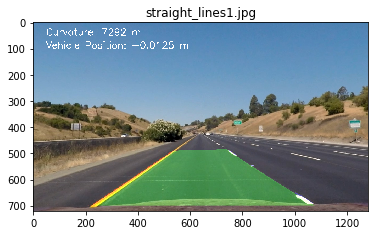

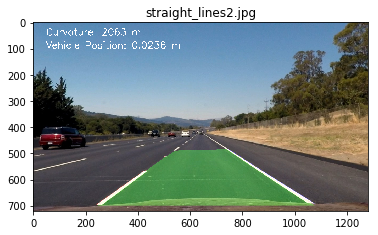

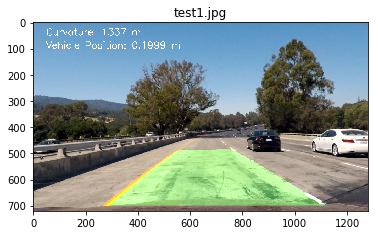

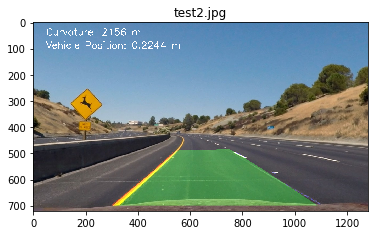

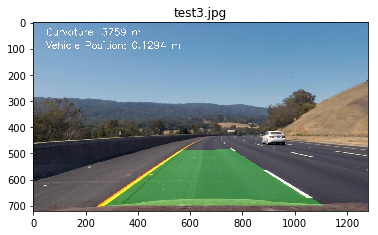

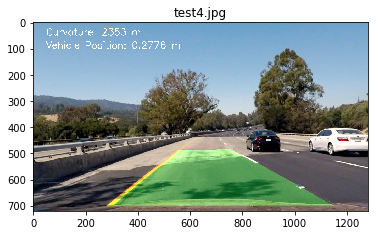

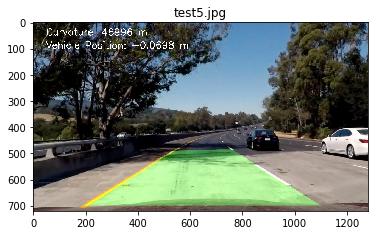

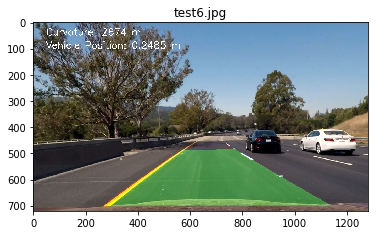

In [9]:
import os
dir = os.listdir("test_images/")

i=0;


for name in dir:
    image = plt.imread('test_images/{}'.format(name))
    leftlines =Line()
    rightlines = Line()
    result = LaneFinding(image)
    plt.figure(i+1)
    plt.imshow (result,'gray')
    plt.title(name)
    i += 1
    plt.imsave('output_images/{}'.format(name),result)



In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
leftlines = Line()
rightlines = Line()
Output = 'test_videos_output/project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")

clip = clip1.fl_image(LaneFinding) #NOTE: this function expects color images!!
%time clip.write_videofile(Output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:38<00:00, 12.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

Wall time: 1min 38s
